# EhV

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from pandas.api.types import CategoricalDtype
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale, power_transform, normalize
import numpy
from multiprocessing import Pool
import pickle

In [4]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale, robust_scale
import umap
from sklearn.model_selection import train_test_split

## Data import

In [5]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [6]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "index.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(102612, 914)

In [ ]:
df.loc["Inf"].reset_index().to_feather(data_dir / f"cells.feather", compression="uncompressed")

In [7]:
selected = df.filter(regex="feat").columns

## Feature correlation

In [6]:
df = df.drop(columns=df.filter(regex='euler').columns)

In [7]:
df = df.loc["Inf"]

In [41]:
%%time
correlation = df.filter(regex="feat.*").corr()

CPU times: user 38.5 s, sys: 35.2 ms, total: 38.5 s
Wall time: 38.7 s


In [42]:
correlation.isna().sum().sum()

0

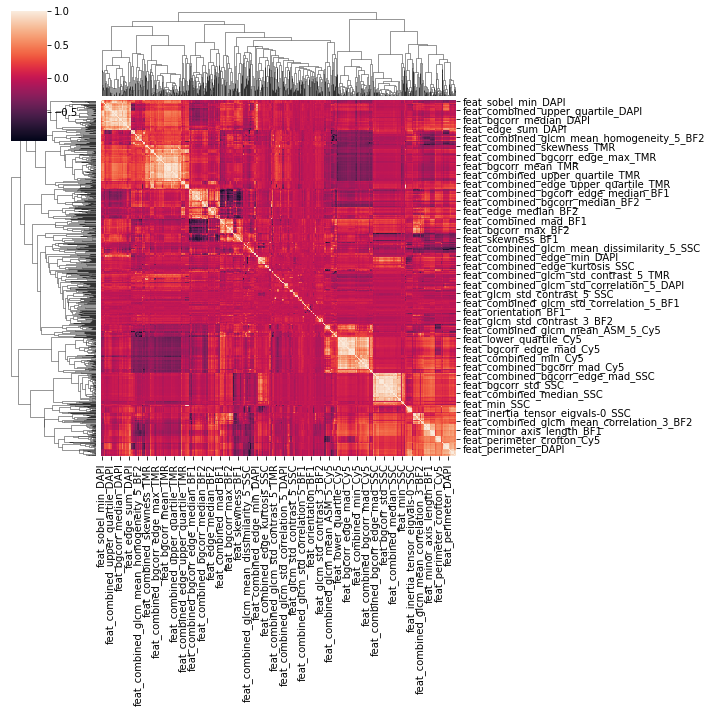

In [43]:
seaborn.clustermap(correlation)

### Pairwise correlated feature removal

In [38]:
def get_correlated_features(df, var, cutoff):
    correlated_features = set()
    correlation = df.corr().abs()
    
    while(numpy.tril(correlation.values, -1).max() > cutoff):
        i,j = numpy.unravel_index(numpy.tril(correlation.values, -1).argmax(), correlation.shape)
        
        if var[correlation.columns[i]] >= var[correlation.columns[j]]:
            colname = correlation.columns[j]
        else:
            colname = correlation.columns[i]
        correlated_features.add(colname)
        
        correlation = df.drop(columns=correlated_features).corr().abs()
                
    return correlated_features

In [39]:
var = df.filter(regex="feat").var()

In [ ]:
%%time
def func(df, var, c):
    correlated_features = get_correlated_features(
        df, var,
        cutoff=c
    )
    corr2 = df.drop(columns=correlated_features).corr()
    corr2 = numpy.abs(corr2.values)
    corr2[numpy.triu_indices(corr2.shape[0], -1)] = numpy.nan
    return numpy.nanmean(corr2), correlated_features

cutoffs = numpy.arange(0.2, 1.001, step=0.01)
res = []
tmp_df = df.filter(regex="feat")
for c in cutoffs[::-1]:
    print(c)
    m, cf = func(tmp_df, var, c)
    tmp_df = tmp_df.drop(columns=cf)

    res.append((c, m, len(cf)))

1.0000000000000007
0.9900000000000007


In [47]:
res = pandas.DataFrame(data=res, columns=["cutoff", "corr", "len"]).set_index("cutoff")

In [48]:
res = res.dropna()

In [21]:
res = res.iloc[1:]

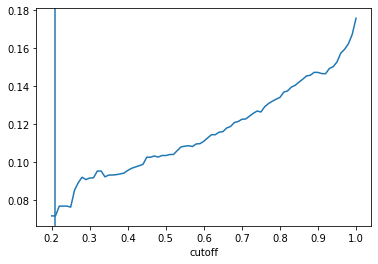

In [49]:
ax = res["corr"].plot()
ax.axvline(res["corr"].idxmin())

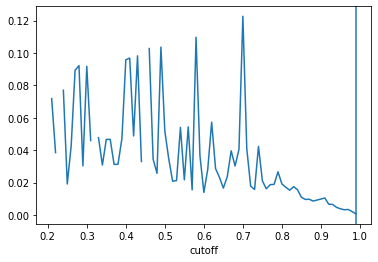

In [50]:
ax = (res["corr"] / res["len"]).plot()
ax.axvline((res["corr"] / res["len"]).idxmin())

In [24]:
c = res["corr"].idxmin()
correlated_features = get_correlated_features(
    corr, var,
    cutoff=c
)

In [25]:
correlation2 = df.filter(regex="feat").drop(columns=correlated_features).corr()

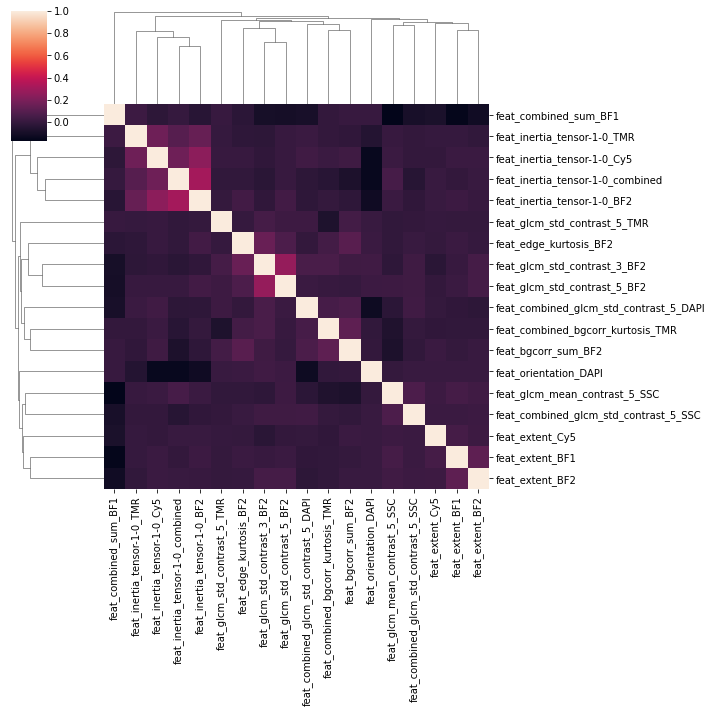

In [26]:
seaborn.clustermap(correlation2)

In [27]:
tmp = correlation2.values.copy()
tmp[numpy.triu_indices(correlation2.shape[0], -1)] = numpy.nan
numpy.nanmean(tmp)

0.0011097585043160477

In [29]:
with open(str(data_dir / f"results/scip/202202071958/pairwise_uncorrelated_cols.txt"), "w") as fh:
    for col in df.filter(regex="feat").drop(correlated_features):
        fh.write(f"{col}\n")

KeyError: 'feat_combined_sobel_min_TMR'

In [ ]:
df = df.drop(columns=correlated_features)

In [ ]:
df.shape

In [ ]:
df.filter(regex="feat")

### Clustering features based on correlation

In [44]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cut_tree

In [45]:
z = fastcluster.linkage(correlation, method="ward")

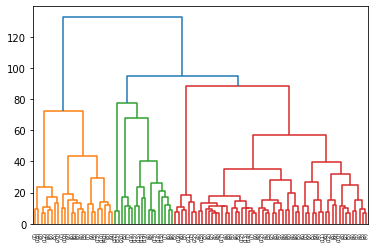

In [46]:
_ = dendrogram(z, truncate_mode="lastp", p=100)

In [68]:
def func(n):
    membership = cut_tree(z, n_clusters=n)[:, 0]
    selected = []
    for i, gdf in df.filter(regex="feat").T.groupby(membership):
        col = correlation[gdf.index].abs().mean(axis=0).idxmin()
        selected.append(col)
    corr2 = df[selected].corr()
    return n, numpy.tril(corr2).mean()

corr_per_feature = []
n_features = numpy.arange(10, df.filter(regex="feat").shape[1], step=10).tolist() + [df.filter(regex="feat").shape[1]]
with Pool(processes=10) as pool:
    res = pool.map_async(func, n_features).get()

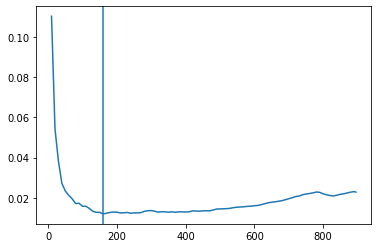

In [136]:
ax = res["corr"].plot()
ax.axvline(res["corr"].idxmin())

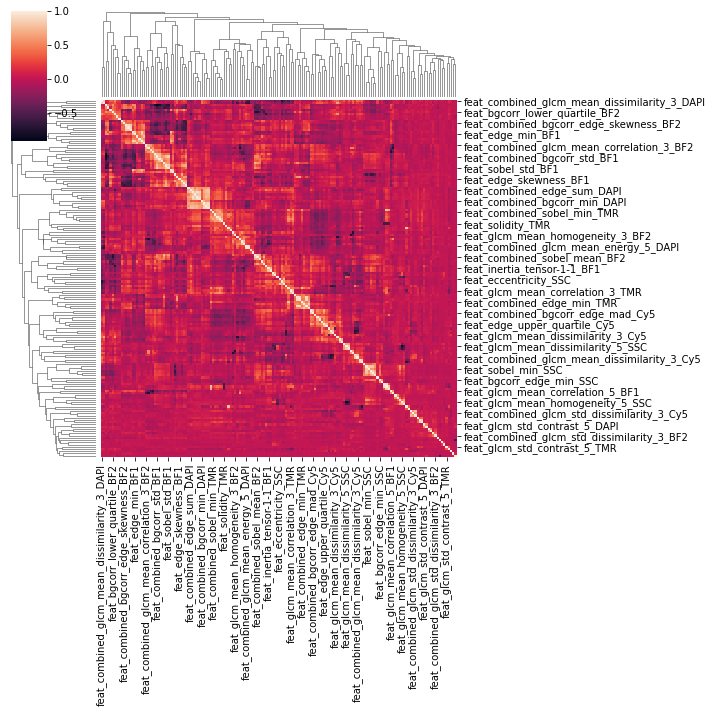

In [91]:
membership = cut_tree(z, n_clusters=res["corr"].idxmin())[:, 0]
selected = []
for i, gdf in df.filter(regex="feat").T.groupby(membership):
    col = correlation[gdf.index].abs().mean(axis=0).idxmin()
    selected.append(col)
corr2 = df[selected].corr()
    
seaborn.clustermap(corr2)

In [121]:
numpy.tril(corr2, -1).max()

0.9429939165538611

In [92]:
with open(str(data_dir / f"results/scip/202202071958/uncorrelated_cols.txt"), "w") as fh:
    for col in selected:
        fh.write(f"{col}\n")

# Dimensionality reduction

In [8]:
with open(data_dir / "rfe/xgb_features.txt", "r") as fh:
    selected = [col[len("scip_"):] for col in fh.read().split(",")]

In [17]:
%%time
pca_all = PCA(n_components=0.95).fit_transform(scale(df[selected].fillna(0)))

CPU times: user 7.82 s, sys: 136 ms, total: 7.96 s
Wall time: 1.78 s


<AxesSubplot:>

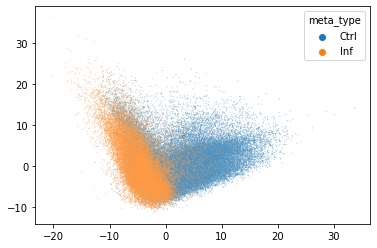

In [18]:
seaborn.scatterplot(x=pca_all[:, 0], y=pca_all[:, 1], hue=df.index.get_level_values("meta_type"), s=1, alpha=0.5, edgecolors="none")

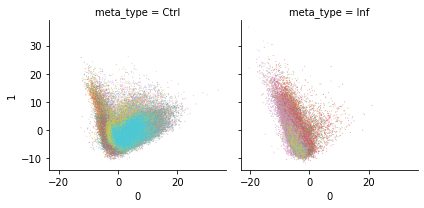

In [19]:
tmp_df = pandas.DataFrame(pca_all)
tmp_df.index = df.index
tmp_df["meta_label"] = df["meta_label"]

grid = seaborn.FacetGrid(data=tmp_df.reset_index(), col="meta_type")
grid.map_dataframe(seaborn.scatterplot, x=0, y=1, hue="meta_group", s=1, alpha=0.5, edgecolors="none")

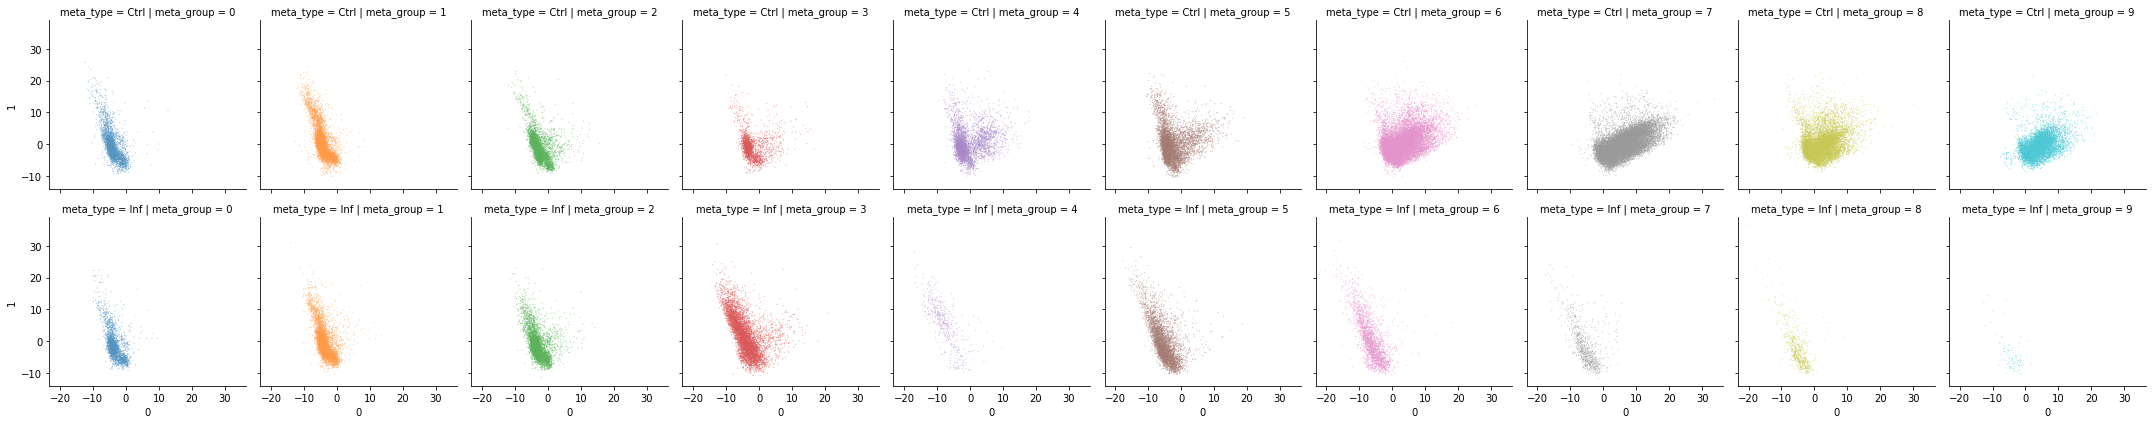

In [20]:
tmp_df = pandas.DataFrame(pca_all)
tmp_df.index = df.index
tmp_df["meta_label"] = df["meta_label"]

grid = seaborn.FacetGrid(data=tmp_df.reset_index(), row="meta_type", col="meta_group")
grid.map_dataframe(seaborn.scatterplot, x=0, y=1, hue="meta_group", s=1, alpha=0.5, edgecolors="none")

In [9]:
sel1 = ~((df.index.get_level_values("meta_group").isin([6,7,8,9])) & (df.index.get_level_values("meta_type") == "Ctrl"))

df = df[sel1]

df.shape

(55569, 914)

### Mutual information

In [10]:
%%time
from sklearn.feature_selection import mutual_info_classif

idx = numpy.random.choice(len(df), size=50000)
X = df[selected].fillna(0).iloc[idx]
target = df.index.get_level_values("meta_type")[idx]

mi = mutual_info_classif(X, target, discrete_features=False, n_neighbors=30, random_state=0)

CPU times: user 40.3 s, sys: 756 ms, total: 41 s
Wall time: 41.3 s


In [11]:
mi = pandas.Series(mi, index=selected).sort_values(ascending=False)

In [12]:
mi.head(n=20)

feat_combined_mean_BF1                   0.409732
feat_mean_BF1                            0.363765
feat_combined_edge_upper_quartile_BF1    0.326581
feat_combined_median_BF1                 0.321832
feat_combined_edge_median_BF1            0.275187
feat_combined_edge_lower_quartile_BF1    0.194765
feat_combined_lower_quartile_BF1         0.187112
feat_edge_median_BF1                     0.126407
feat_combined_mean_BF2                   0.113954
feat_combined_median_BF2                 0.092891
feat_inertia_tensor_eigvals-1_BF1        0.087653
feat_minor_axis_length_BF1               0.087627
feat_mean_BF2                            0.081742
feat_combined_kurtosis_BF1               0.075485
feat_combined_edge_lower_quartile_BF2    0.075473
feat_glcm_mean_energy_5_BF1              0.074721
feat_combined_glcm_mean_energy_5_BF1     0.074060
feat_combined_kurtosis_BF2               0.073907
feat_combined_skewness_BF1               0.072942
feat_combined_upper_quartile_BF2         0.069429


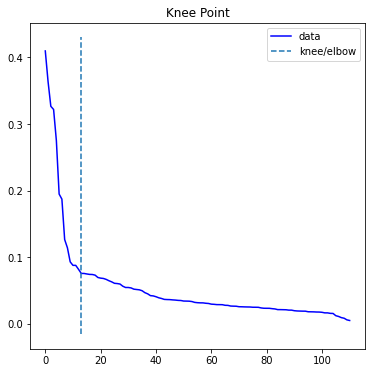

In [13]:
from kneed import KneeLocator

kneedle = KneeLocator(numpy.arange(len(mi)), mi, S=10, curve='convex', direction="decreasing",online=False)
elbow_value = mi.iloc[int(kneedle.knee)]

kneedle.plot_knee()

In [80]:
%%time
pca = PCA().fit_transform(scale(df[mi[mi < elbow_value].index].fillna(0)))

CPU times: user 3.27 s, sys: 54.8 ms, total: 3.32 s
Wall time: 521 ms


<AxesSubplot:>

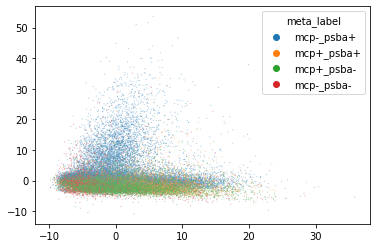

In [81]:
seaborn.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=df["meta_label"], s=1, alpha=0.5, edgecolors="none")

In [14]:
selected_mi = mi[mi < elbow_value].index.values

len(selected_mi)

97

## T-SNE

In [58]:
%%time
tsne = TSNE(n_components=2, n_jobs=16, random_state=0, init="pca", learning_rate="auto").fit_transform(scale(df[selected].fillna(0)))

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


CPU times: user 16min 38s, sys: 42.5 s, total: 17min 20s
Wall time: 3min 18s


In [7]:
with open(data_dir / "dimred/tsne.pickle", "rb") as fh:
    tsne = pickle.load(fh)

In [10]:
with open(data_dir / "dimred/tsne.pickle", "wb") as fh:
    pickle.dump(tsne, fh)

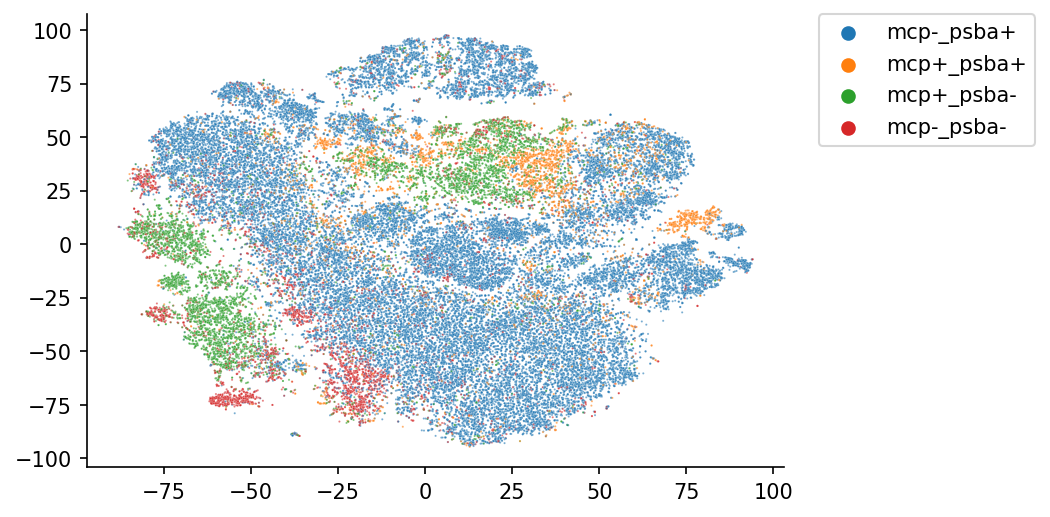

In [59]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.6, edgecolors="none", hue=df["meta_label"], ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)
# plt.savefig(data_dir / "figures/tsne_color_class.pdf", bbox_inches="tight")

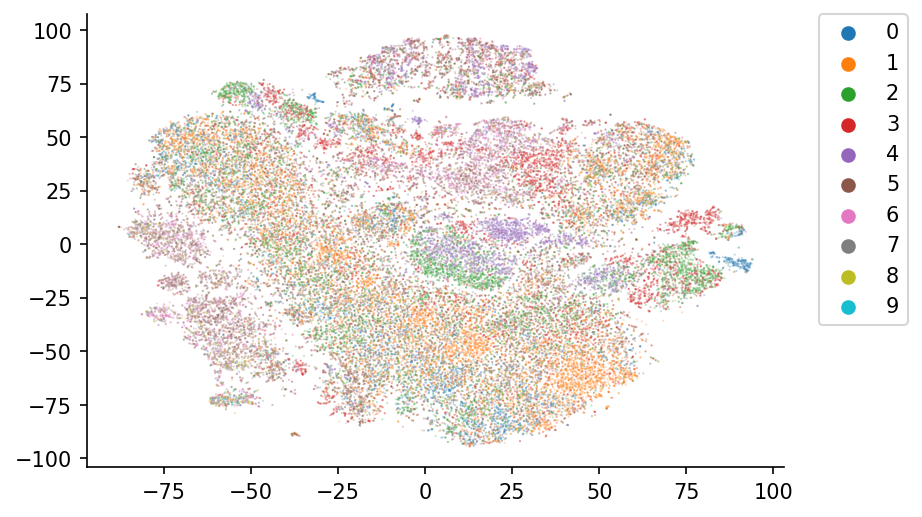

In [60]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.3, edgecolors="none", hue=df.index.get_level_values("meta_group"), ax=ax)
seaborn.despine(fig)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig(data_dir / "figures/tsne_color_group.pdf", bbox_inches="tight")

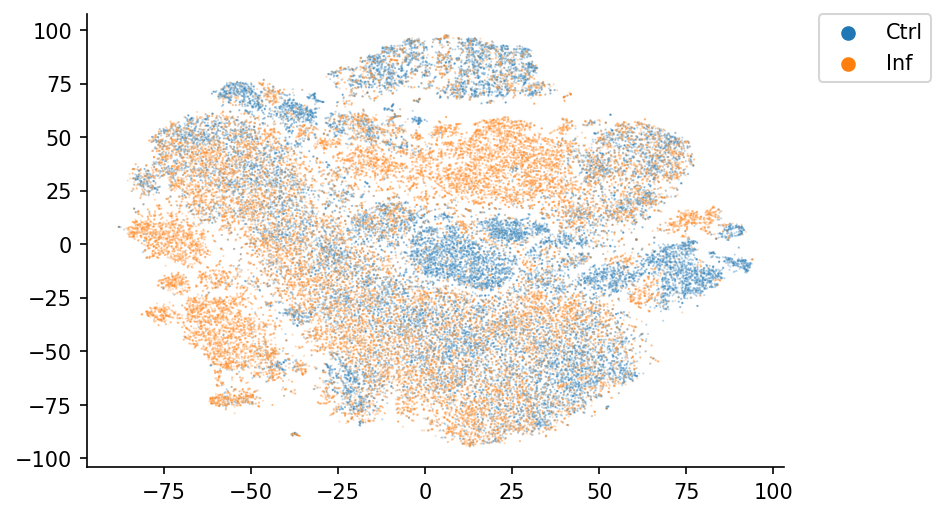

In [61]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.3, edgecolors="none", hue=df.index.get_level_values("meta_type"), ax=ax)
seaborn.despine(fig)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig(data_dir / "figures/tsne_color_group.pdf", bbox_inches="tight")

In [82]:
top5 = pandas.read_csv("../top5.csv", index_col=0)

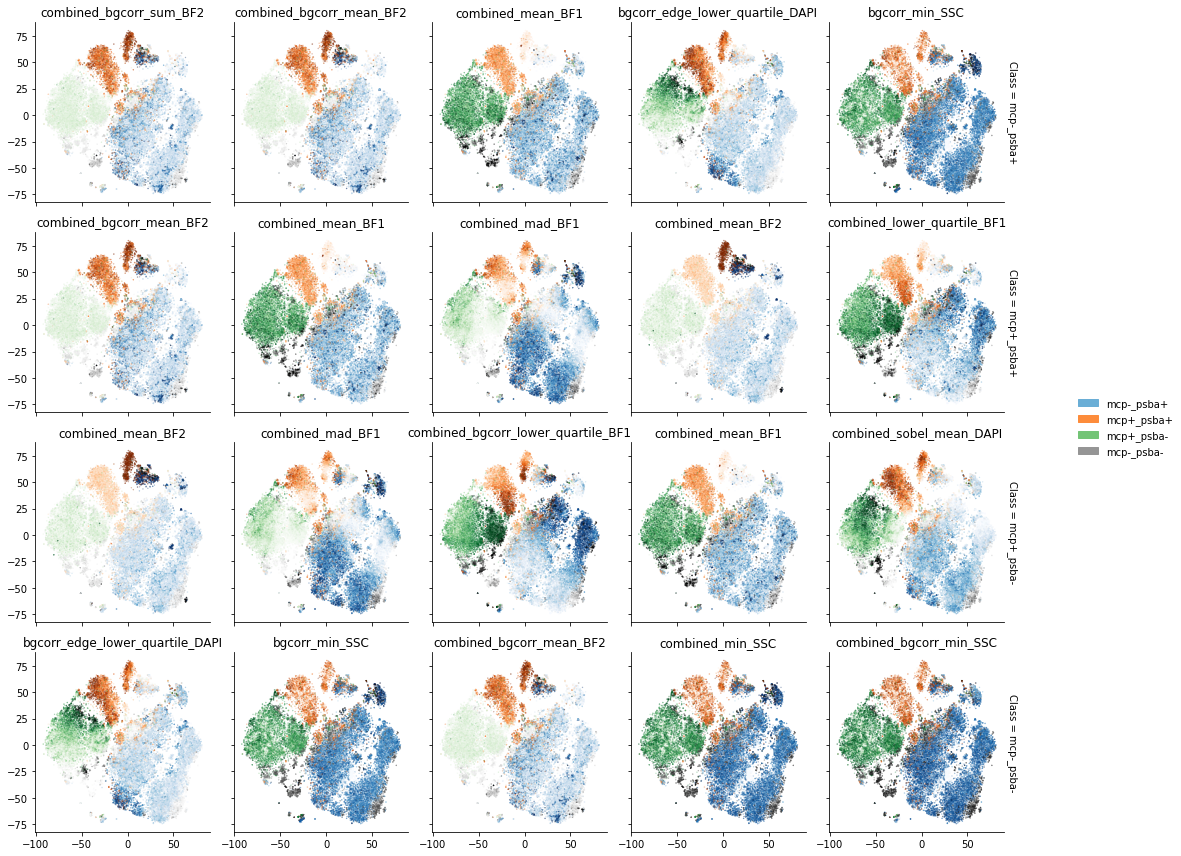

In [106]:
import matplotlib.patches as mpatches

def draw_dimred(data, x, *args, **kwargs):
    f = data[x].iloc[0][len("scip_"):]
    ax = plt.gca()
    norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][f].quantile(0.05), vmax=df.loc["Inf"][f].quantile(0.95))
    
    for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
        sel = df.loc["Inf"]["meta_label"] == cat
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap=cmap, norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)

grid = seaborn.FacetGrid(data=top5, row="Class", col="Rank", margin_titles=True)

legend_data = {}
for cat, cmap in zip(df["meta_label"].cat.categories, ["Blues", "Oranges", "Greens", "Greys"]):
    legend_data[cat] = mpatches.Patch(color=plt.get_cmap(cmap)(0.5), label=cat)
grid.add_legend(legend_data=legend_data)

grid.map_dataframe(draw_dimred, x="Feature")
for (c, r), ax in grid.axes_dict.items():
    f = top5.set_index(["Class", "Rank"]).loc[c, r]["Feature"]
    ax.set_title(f[len("scip_feat_"):])
    
grid.set_xlabels("")
grid.tight_layout()

plt.savefig(data_dir / "figures/tsne_color_top5_shap.png", bbox_inches="tight", dpi=150)

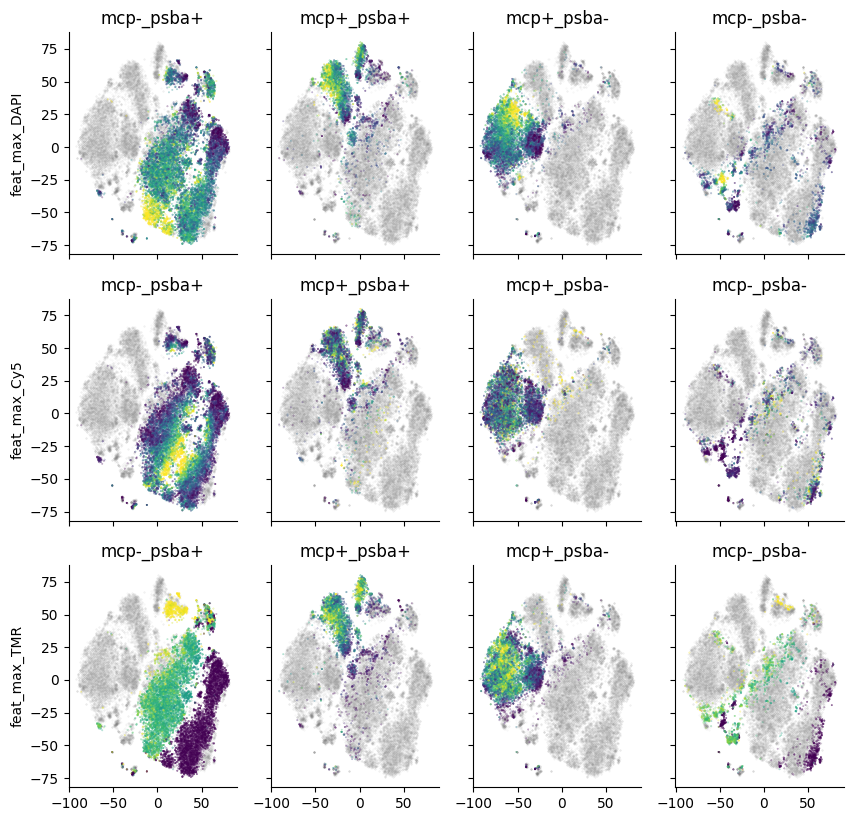

In [107]:
fig, axes = plt.subplots(3, 4, dpi=100, figsize=(10, 10), sharex=True, sharey=True)

for f, row in zip(["feat_max_DAPI", "feat_max_Cy5", "feat_max_TMR"], axes):

    row[0].set_ylabel(f)
    for ax, cat in zip(row, df["meta_label"].cat.categories):
        sel = df.loc["Inf"]["meta_label"] == cat
        norm = matplotlib.colors.Normalize(vmin=df.loc["Inf"][sel][f].quantile(0.05), vmax=df.loc["Inf"][sel][f].quantile(0.95))
        ax.scatter(x=tsne[~sel, 0], y=tsne[~sel, 1], c="grey", s=0.1, alpha=0.1)
        ax.scatter(x=tsne[sel, 0], y=tsne[sel, 1], cmap="viridis", norm=norm, c=df.loc["Inf"][sel][f], s=0.1, alpha=0.5)
        ax.set_title(cat)

seaborn.despine(fig)

plt.savefig(data_dir / "figures/tsne_color_fluor.png", bbox_inches="tight", dpi=150)

## UMAP

In [74]:
import umap

In [75]:
%%time
umap_ = umap.UMAP(n_components=2, metric="cosine", n_neighbors=5, min_dist=0.1).fit_transform(scale(df[selected_mi].fillna(0)))

CPU times: user 3min 9s, sys: 991 ms, total: 3min 10s
Wall time: 31.8 s


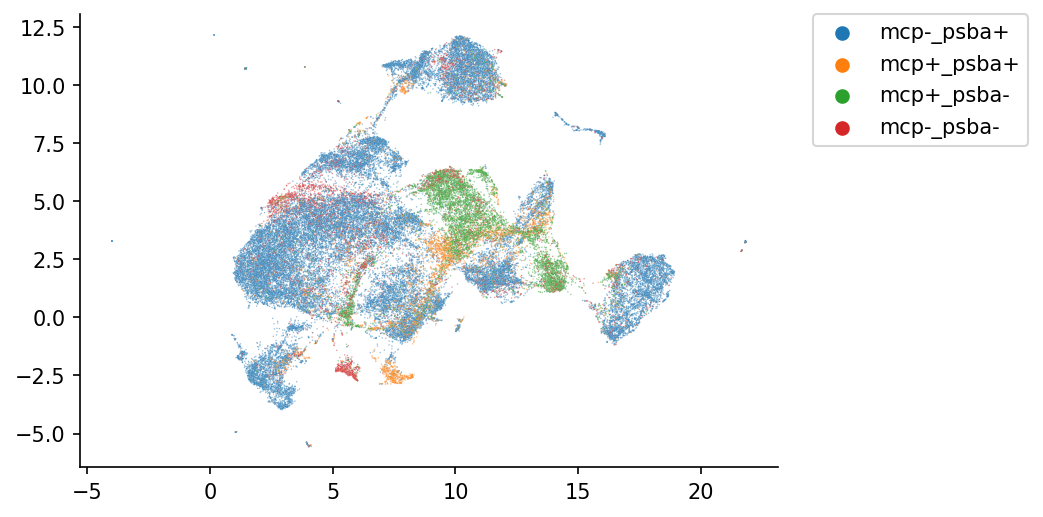

In [76]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, alpha=0.5, edgecolors="none", hue=df["meta_label"], ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)
# plt.savefig(data_dir / "figures/tsne_color_class.pdf", bbox_inches="tight")

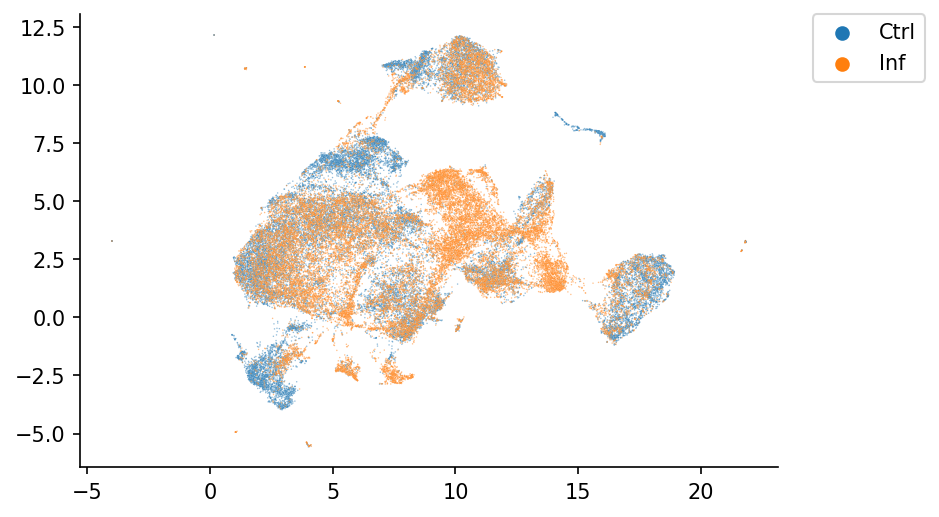

In [77]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, alpha=0.5, edgecolors="none", hue=df.index.get_level_values("meta_type"), ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)
# plt.savefig(data_dir / "figures/tsne_color_class.pdf", bbox_inches="tight")

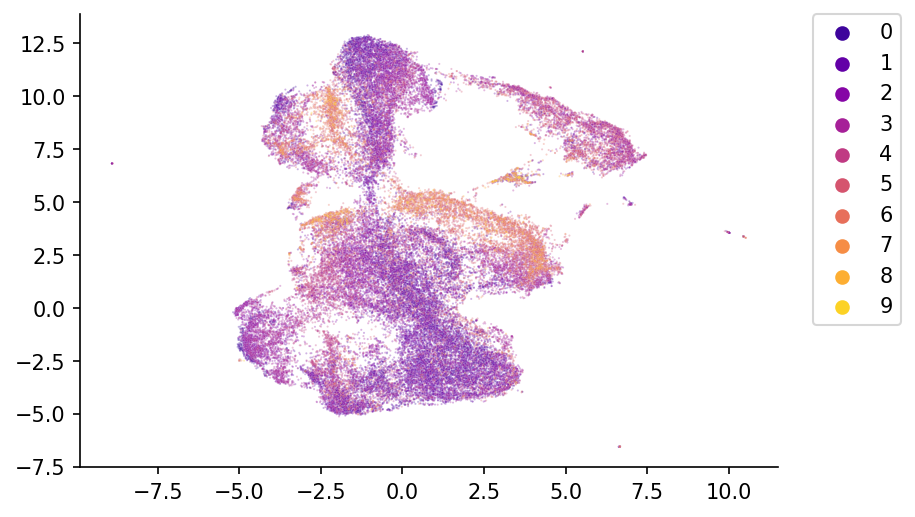

In [105]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=1, alpha=0.3, edgecolors="none", palette="plasma", hue=df.index.get_level_values("meta_group"), ax=ax)
seaborn.despine(fig)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig(data_dir / "figures/tsne_color_group.pdf", bbox_inches="tight")

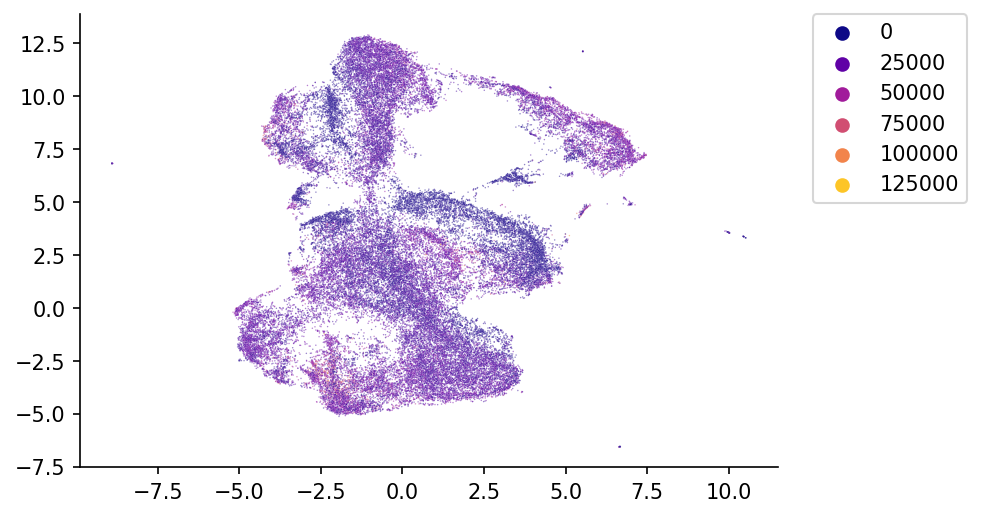

In [107]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap_[:, 0], y=umap_[:, 1], s=0.5, alpha=0.5, edgecolors="none", palette="plasma", hue=df["feat_sum_Cy5"], ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)
# plt.savefig(data_dir / "figures/tsne_color_class.pdf", bbox_inches="tight")

# Clustering

In [15]:
import igraph
import leidenalg

In [16]:
from scipy.spatial.distance import pdist, squareform

In [78]:
idx = numpy.random.choice(len(df), size=10000)
sampled_df = df[selected_mi].iloc[idx]

In [79]:
d = squareform(pdist(sampled_df, metric="cosine"))

In [80]:
%%time
G = igraph.Graph.Adjacency((d > 0) & (d < 0.02))

CPU times: user 9.14 s, sys: 172 ms, total: 9.32 s
Wall time: 9.35 s


In [81]:
%%time
partition = leidenalg.find_partition(G, leidenalg.ModularityVertexPartition)

CPU times: user 38.1 s, sys: 17.1 ms, total: 38.1 s
Wall time: 38.2 s


In [82]:
numpy.unique(partition.membership)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

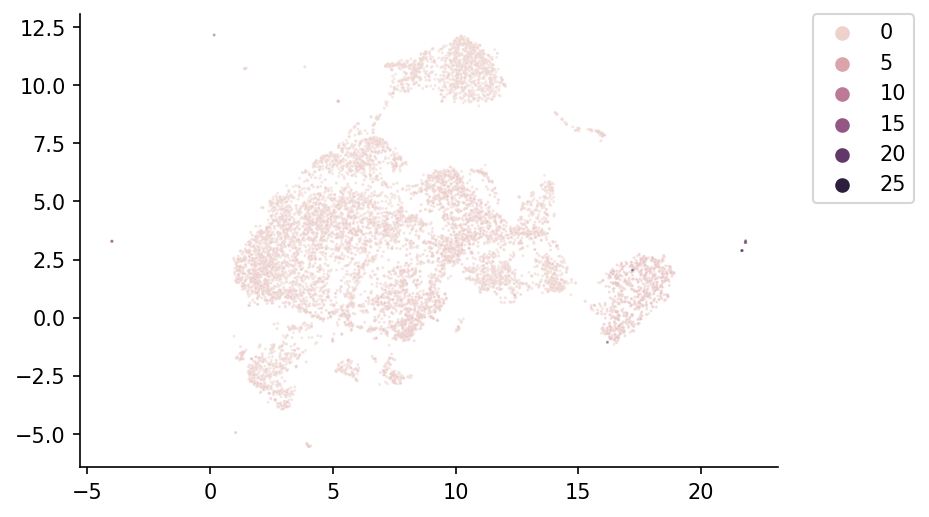

In [84]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=umap_[idx, 0], y=umap_[idx, 1], s=2, alpha=0.5, edgecolors="none", hue=partition.membership, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)
# plt.savefig(data_dir / "figures/tsne_color_class.pdf", bbox_inches="tight")

## FlowSOM

In [52]:
with open(str(data_dir / "fluor+morphpca_metaclusters.txt")) as fh:
    clusters = numpy.array(fh.read().split("\n")[:-1], dtype=int)

In [56]:
cat_type = CategoricalDtype(categories=sorted(numpy.unique(clusters)), ordered=True)
df["meta_clusters"] = -1
df.loc["Inf", "meta_clusters"] = clusters
df["meta_clusters"] = df["meta_clusters"].astype(cat_type)

/apps/gent/CO7/skylake-ib/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


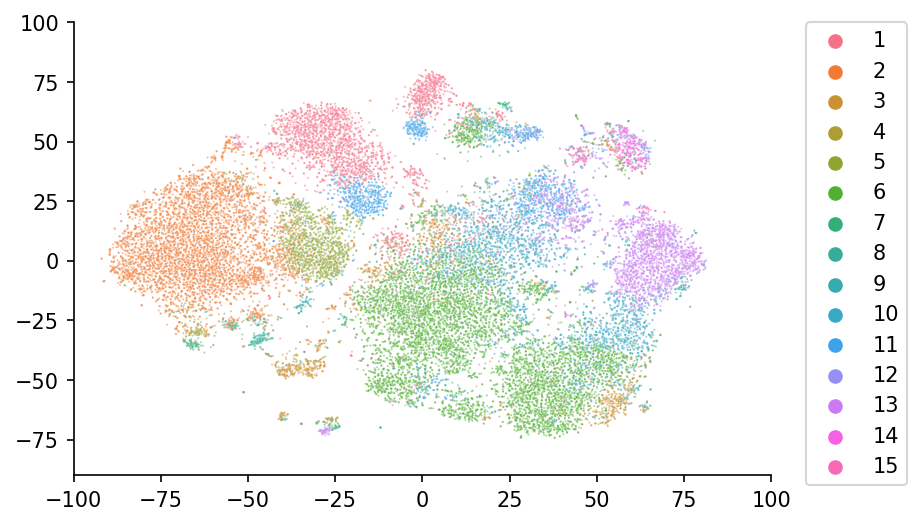

In [57]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf"]["meta_clusters"], ax=ax)
ax.set_xlim(-100, 100)
ax.set_ylim(-90, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)

In [67]:
cluster_abundances = df.loc["Inf"].groupby(["meta_clusters", "meta_label"]).size() / df.loc["Inf"].groupby("meta_clusters").size()

In [89]:
max_abundance = cluster_abundances.groupby("meta_clusters").idxmax()
for r in max_abundance:
    if r[1] == "mcp-_psba-":
        print(r)

(3, 'mcp-_psba-')
(4, 'mcp-_psba-')
(8, 'mcp-_psba-')
(9, 'mcp-_psba-')


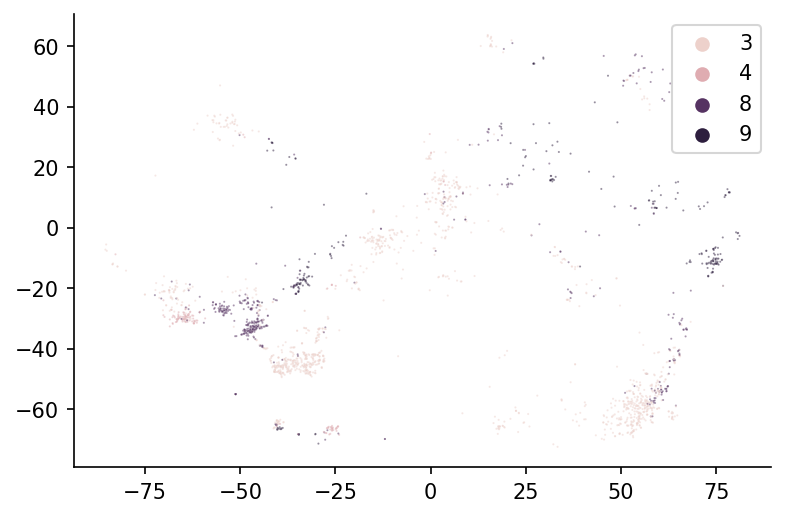

In [99]:
fig, ax = plt.subplots(dpi=150)
sel = df.loc["Inf"]["meta_clusters"].isin([3, 4, 8, 9])
seaborn.scatterplot(x=tsne[sel, 0], y=tsne[sel, 1], s=1, alpha=0.5, hue=df.loc["Inf"]["meta_clusters"][sel].tolist(), edgecolors="none", ax=ax)
seaborn.despine(fig)

In [59]:
with open(str(data_dir / "fluor_metaclusters.txt")) as fh:
    clusters = numpy.array(fh.read().split("\n")[:-1], dtype=int)

In [60]:
cat_type = CategoricalDtype(categories=sorted(numpy.unique(clusters)), ordered=True)
df["meta_fluor_clusters"] = -1
df.loc["Inf", "meta_fluor_clusters"] = clusters
df["meta_fluor_clusters"] = df["meta_fluor_clusters"].astype(cat_type)

/apps/gent/CO7/skylake-ib/software/IPython/7.26.0-GCCcore-11.2.0/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


/tmp/ipykernel_65958/2792013934.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf", "meta_fluor_clusters"])


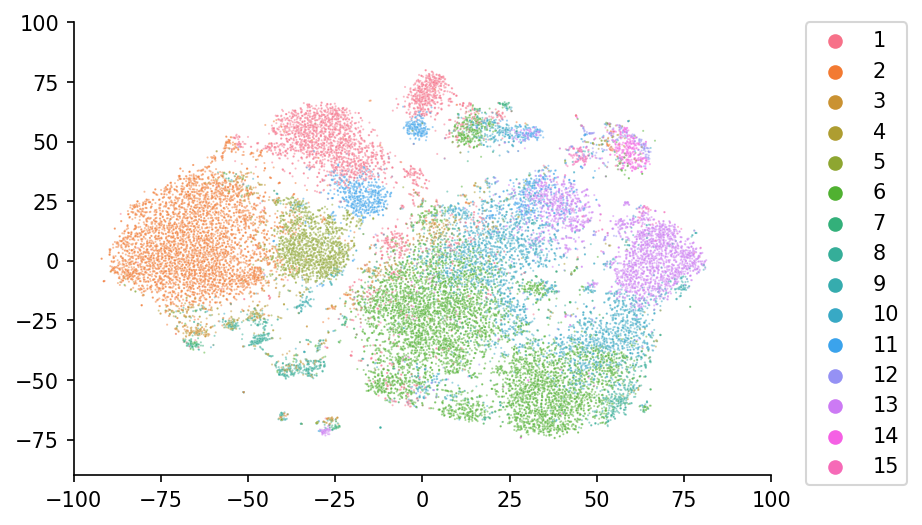

In [61]:
fig, ax = plt.subplots(dpi=150)
seaborn.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=1, alpha=0.5, edgecolors="none", hue=df.loc["Inf", "meta_fluor_clusters"])
ax.set_xlim(-100, 100)
ax.set_ylim(-90, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
seaborn.despine(fig)

In [92]:
metrics.adjusted_rand_score(df.loc["Inf"]["meta_clusters"], df.loc["Inf"]["meta_fluor_clusters"])

0.8133630882592933

In [93]:
metrics.adjusted_mutual_info_score(df.loc["Inf"]["meta_clusters"], df.loc["Inf"]["meta_fluor_clusters"])

0.8274372457210468